<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Checklist" data-toc-modified-id="Checklist-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Checklist</a></span></li></ul></div>

# Taxi Order Forecasting

The company "Chetenkoe Taxi" collected historical data on taxi orders at airports. To attract more drivers during peak periods, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such a prediction.

The *RMSE* metric value on the test set should not exceed 48.

You need to:

1. Load the data and resample it by one hour.
2. Analyze the data.
3. Train different models with various hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.

The data is in the file `taxi.csv`. The number of orders is in the column `num_orders`.

In [44]:
# pip install -r requirements.txt

In [45]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
import lightgbm as lgb

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [46]:
RANDOM_STATE = 44
TEST_SIZE = 0.1

Success: Imports are in place.

## Preparation

In [47]:
df = pd.read_csv('taxi.csv', parse_dates=[0])
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Success: Good use of parse_dates, you can also add index_col.

In [48]:
df.datetime.describe()

count                  26496
mean     2018-05-31 23:55:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:57:30
50%      2018-05-31 23:55:00
75%      2018-07-16 23:52:30
max      2018-08-31 23:50:00
Name: datetime, dtype: object

**The dataset contains data for 3 months.**

In [49]:
df = df.set_index('datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Resample the data by one hour.**

In [50]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [51]:
df.isnull().sum()

num_orders    0
dtype: int64

**No missing values.**

Success: Initial inspection done, resampling was correct.

## Analysis

**Plot the time series with moving average.**

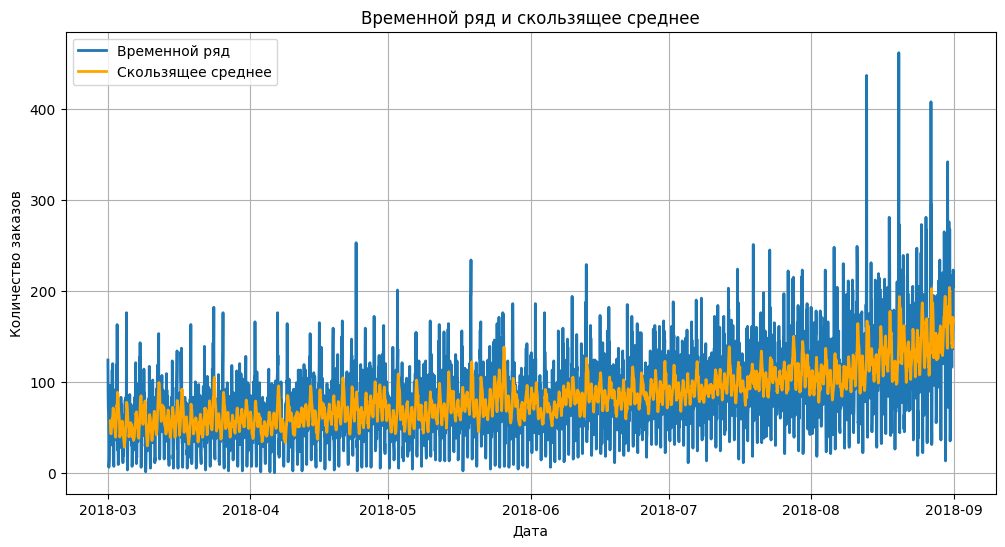

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['num_orders'], label='Временной ряд', linewidth=2)
plt.plot(df.index, df['num_orders'].rolling(12, closed='left').mean(), label='Скользящее среднее', color='orange', linewidth=2)
plt.title('Временной ряд и скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

**It is difficult to say visually if the standard deviation changes, let's check the series with the Dickey-Fuller test for stationarity.**

In [53]:
result = adfuller(df['num_orders'])
print(f"p-value: {result[1]}")

p-value: 0.0289400514026128


**P-value is less than the critical 5%, the series can be considered stationary.**

Info:

Strictly speaking, our series is not stationary, as it has not only a trend but also acceleration from August (quadratic trend). The variance is also not constant.

However, there are methods to make the series stationary. For example, taking the difference removes the trend. Box-Cox transformation removes variance heterogeneity. Seasonal differencing removes seasonality.

Our models can predict the series without all these transformations. We only need to test if the series can be made stationary. In ML tasks, a series that can be made stationary is often called stationary for simplicity, but strictly by definition, it is not.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Понятно, исправил результат теста.
</div>

Success: Done.

**Now let's look at the trend and seasonality plots.**

In [54]:
decomposed = seasonal_decompose(df)

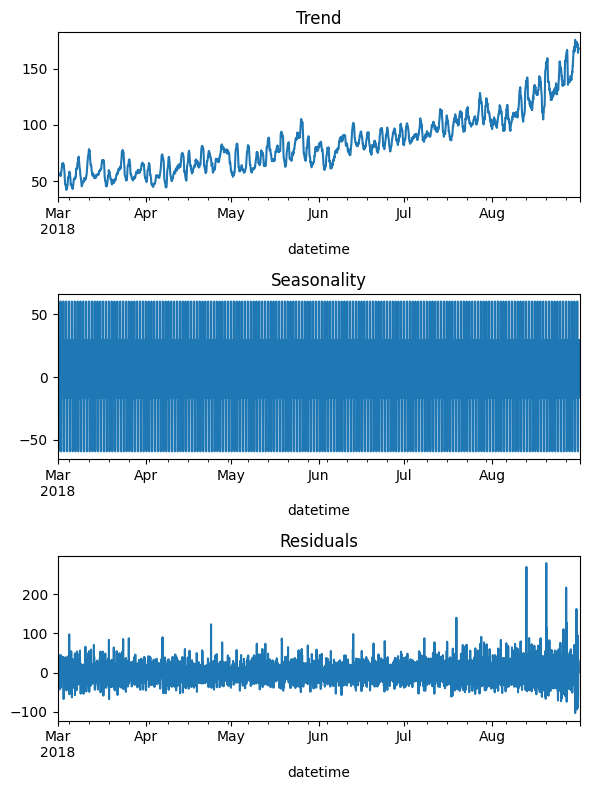

In [55]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**There is an increasing trend, let's look at August, where our test data is located, in more detail.**

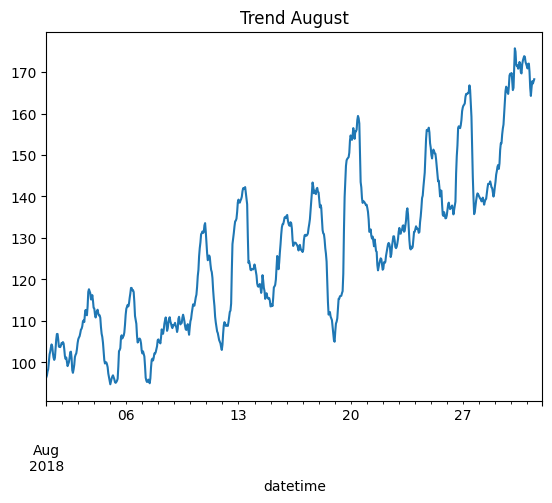

In [56]:
decomposed.trend['2018-08-01':'2018-08-31'].plot()
plt.title('Trend August');

**Overall, the trend is increasing, but there are jumps in the opposite direction, for example on the 18th-19th.**

**Now let's look at seasonality over a shorter period, for example during a day.**

Text(0.5, 1.0, 'Seasonality')

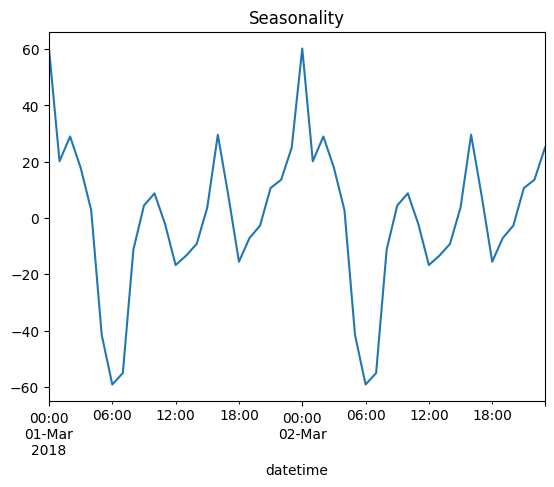

In [57]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.title('Seasonality')

**The least popular time to order a taxi is 6 am, with activity spikes around 8 am (people go to work), 4-5 pm (people return from work/study), and the highest peak around midnight.**

In [58]:
df_day = df.resample('1D').sum()

In [59]:
df_day.loc[['2018-04-01']].index.dayofweek.values[0]

6

**April 1, 2018 is a Sunday.**

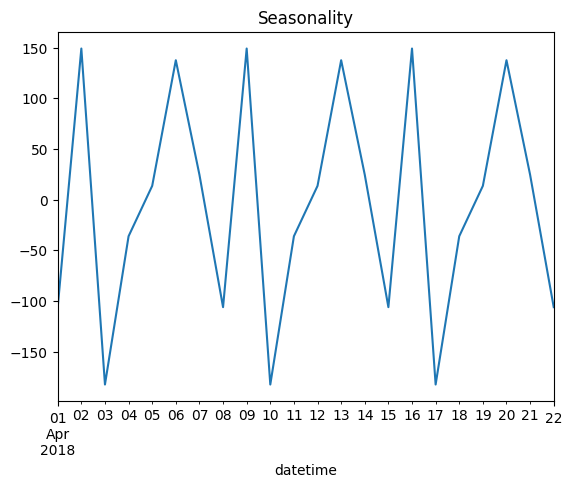

In [60]:
decomposed_wd = seasonal_decompose(df_day)
decomposed_wd.seasonal['2018-04-01':'2018-04-22'].plot()
plt.title('Seasonality');

**Weekly seasonality shows that on Monday order activity increases compared to Sunday, then drops on Tuesday, then grows until Friday, and drops again by Sunday.**

Text(0.5, 1.0, 'Seasonality')

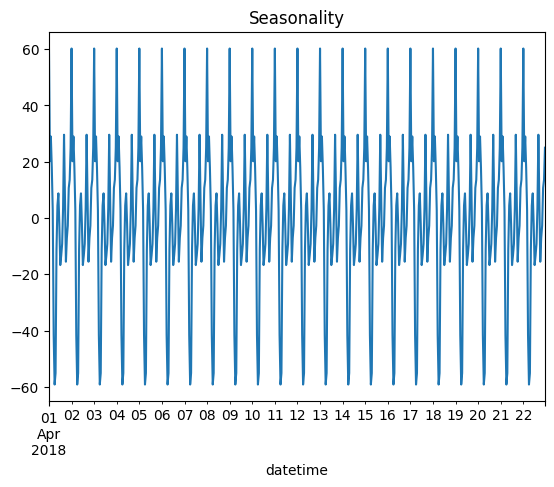

In [61]:
decomposed.seasonal['2018-04-01':'2018-04-22'].plot()
plt.title('Seasonality')

**Let's look at the distribution of residuals in July-August.**

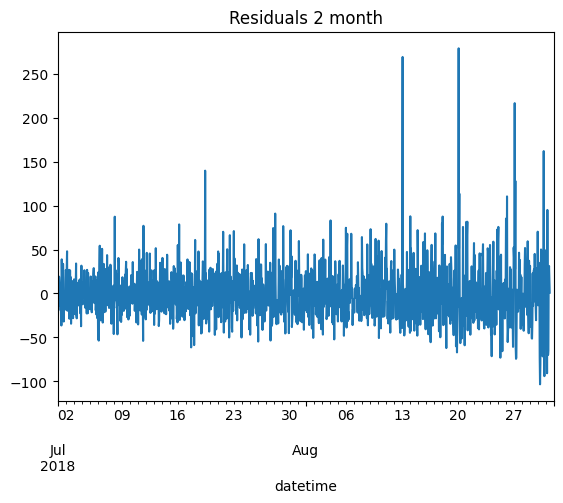

In [62]:
decomposed.resid['2018-07-01':'2018-08-31'].plot()
plt.title('Residuals 2 month');

**There is more noise and more outliers in August compared to the previous month, so the model quality may decrease on the test data.**

## Training

**Add features: day of week, hour, holiday indicator, configurable lag, and rolling mean with a specified window size.**

In [63]:
ru_holidays = holidays.Russia()

In [64]:
def make_features(df, max_lag, rolling_mean_size):
    df_features = df.copy()
    df_features['dayofweek'] = df.index.dayofweek
    df_features['hour'] = df.index.hour
    df_features['is_holiday'] = df.index.isin(ru_holidays).astype(int)
    for lag in range(1, max_lag + 1):
        df_features['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df_features['rolling_mean'] = df['num_orders'].shift(1)\
    .rolling(rolling_mean_size).mean()
    return df_features

Error: Calendar features highlight seasonality. If we have daily seasonality, hour is a logical feature; if weekly, day of week. Month is not suitable since we only have one March, May, etc. The forecast horizon is hours.

Other features are fine.

In [65]:
df_main = make_features(df, 2, 24)

In [66]:
df_main.head()

,num_orders,dayofweek,hour,is_holiday,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,0,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,0,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,0,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,0,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,0,66.0,71.0,NaN


**Split the data into train and test sets, remove missing values from the train set, test set is 10% of the data.**

In [67]:
train, test = train_test_split(df_main, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
y_train = train['num_orders']
y_test = test['num_orders']
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)

**We will use two models: Ridge regression and LightGBM. Hyperparameters will be tuned with GridSearchCV.**

In [68]:
param_grid_lgbm = [
    {
        'num_leaves': [30, 50, 70],
        'max_depth': [5, 10, 15]
    }]
param_grid_ridge = [    
    {
    'alpha': [0.1, 0.5, 1, 2.5, 3.5,  5, 10]
    }]

**Define custom RMSE metric.**

In [69]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [70]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [71]:
model_ridge = Ridge()
model_lgbm = lgb.LGBMRegressor(n_estimators=20,
                               learning_rate=0.15,
                               verbose=-1,
                               random_state=RANDOM_STATE)

In [72]:
grid_search_ridge = GridSearchCV(
    estimator=model_ridge,
    param_grid=param_grid_ridge,
    scoring=rmse_scorer,
    cv=TimeSeriesSplit(n_splits=3)
)
grid_search_ridge.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Ridge(),
             param_grid=[{'alpha': [0.1, 0.5, 1, 2.5, 3.5, 5, 10]}],
             scoring=make_scorer(rmse, greater_is_better=False))

Success: Like for TimeSeriesSplit, this is important for cross-validation.

In [73]:
grid_search_ridge.best_estimator_

Ridge(alpha=10)

In [74]:
print('Лучшая модель и её параметры:\n\n', grid_search_ridge.best_estimator_)
print ('Метрика лучшей модели на кроссвалидационной выборке:', grid_search_ridge.best_score_)

Лучшая модель и её параметры:

 Ridge(alpha=10)
Метрика лучшей модели на кроссвалидационной выборке: -32.79170907543201


**Grid search for Ridge regression done, best alpha = 0.1, RMSE = 32.8 on cross-validation.**

In [75]:
grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring=rmse_scorer,
    cv=TimeSeriesSplit(n_splits=5)
)
grid_search_lgbm.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(learning_rate=0.15, n_estimators=20,
                                     random_state=44, verbose=-1),
             param_grid=[{'max_depth': [5, 10, 15],
                          'num_leaves': [30, 50, 70]}],
             scoring=make_scorer(rmse, greater_is_better=False))

In [76]:
grid_search_lgbm.best_estimator_

LGBMRegressor(learning_rate=0.15, max_depth=15, n_estimators=20, num_leaves=50,
              random_state=44, verbose=-1)

In [77]:
print('Лучшая модель и её параметры:\n\n', grid_search_lgbm.best_estimator_)
print ('Метрика лучшей модели на кроссвалидационной выборке:', grid_search_lgbm.best_score_)

Лучшая модель и её параметры:

 LGBMRegressor(learning_rate=0.15, max_depth=15, n_estimators=20, num_leaves=50,
              random_state=44, verbose=-1)
Метрика лучшей модели на кроссвалидационной выборке: -25.378085111637372


**LightGBMRegressor achieved a better metric than Ridge, will use it for test data.**

## Testing

**Train the model with the best hyperparameters.**

In [78]:
model_best = lgb.LGBMRegressor(max_depth=15,
                               n_estimators=30, 
                               num_leaves=50,
                               verbose=3,
                               learning_rate=0.15,
                               random_state=RANDOM_STATE)

In [79]:
model_best.fit(X_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.037114
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000466 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 5
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Tra

LGBMRegressor(learning_rate=0.15, max_depth=15, n_estimators=30, num_leaves=50,
              random_state=44, verbose=3)

In [80]:
y_pred = model_best.predict(X_test)
print('Метрика RMSE лучшей модели на кроссвалидационной выборке:', rmse(y_test, y_pred))

Метрика RMSE лучшей модели на кроссвалидационной выборке: 44.545513045945874


In [81]:
results = pd.DataFrame(data=y_test)
results['pred'] = y_pred
results['resid'] = results['num_orders'] - results['pred'] 
results.tail(5)

,num_orders,pred,resid
datetime,,,
2018-08-31 19:00:00,136,111.772242,24.227758
2018-08-31 20:00:00,154,113.730730,40.269270
2018-08-31 21:00:00,159,145.557257,13.442743
2018-08-31 22:00:00,223,149.573505,73.426495
2018-08-31 23:00:00,205,144.677051,60.322949


**The model achieved RMSE < 48 on the test data, success.**

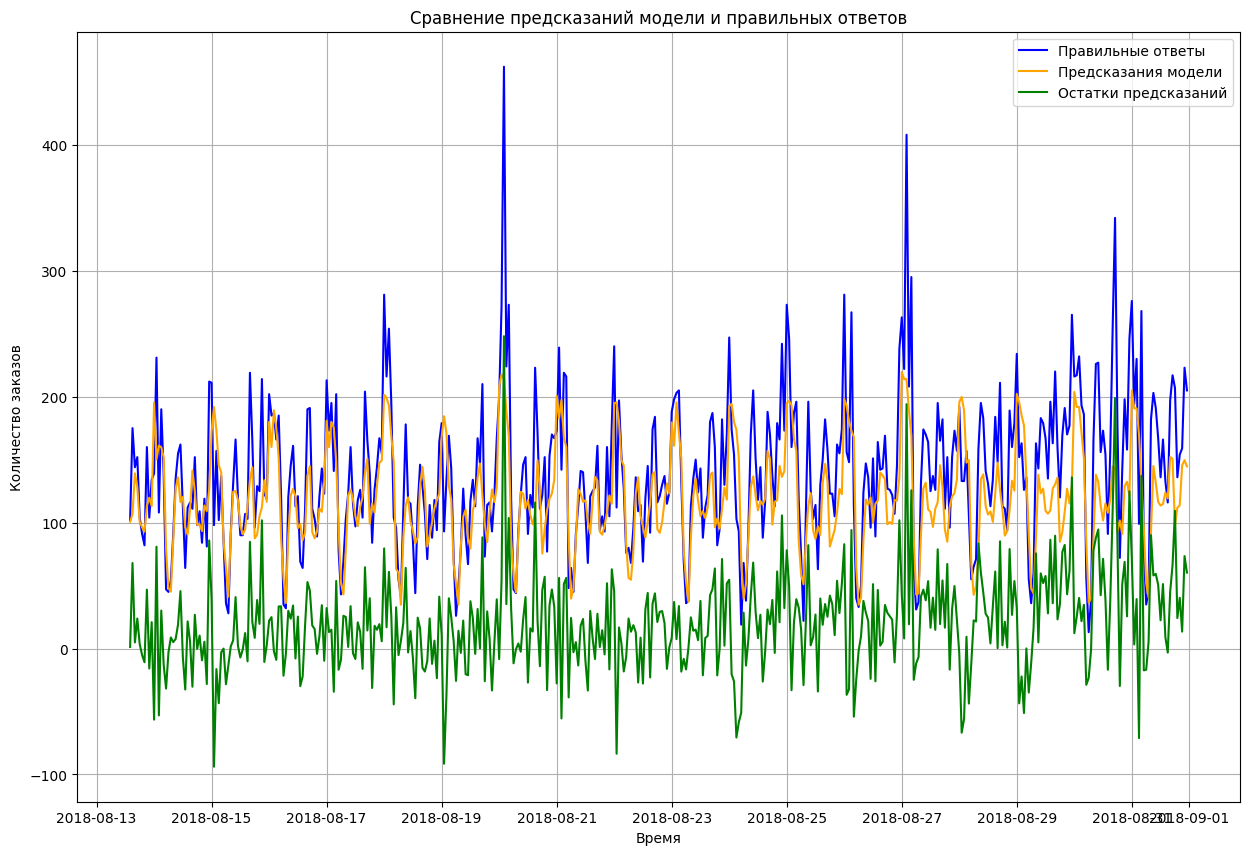

In [82]:
plt.figure(figsize=(15, 10))
plt.plot(results['num_orders'], label='Правильные ответы', color='blue')
plt.plot(results['pred'], label='Предсказания модели', color='orange')
plt.plot(results['resid'], label='Остатки предсказаний', color='green')
plt.title("Сравнение предсказаний модели и правильных ответов")
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()


**The model failed to capture sharp increases in activity in several places, let's look at the same graph for one week.**

In [83]:
results = results['2018-08-15':'2018-08-22']
results.loc[['2018-08-15']].index.dayofweek.values[0]

2

**August 15 is Wednesday.**

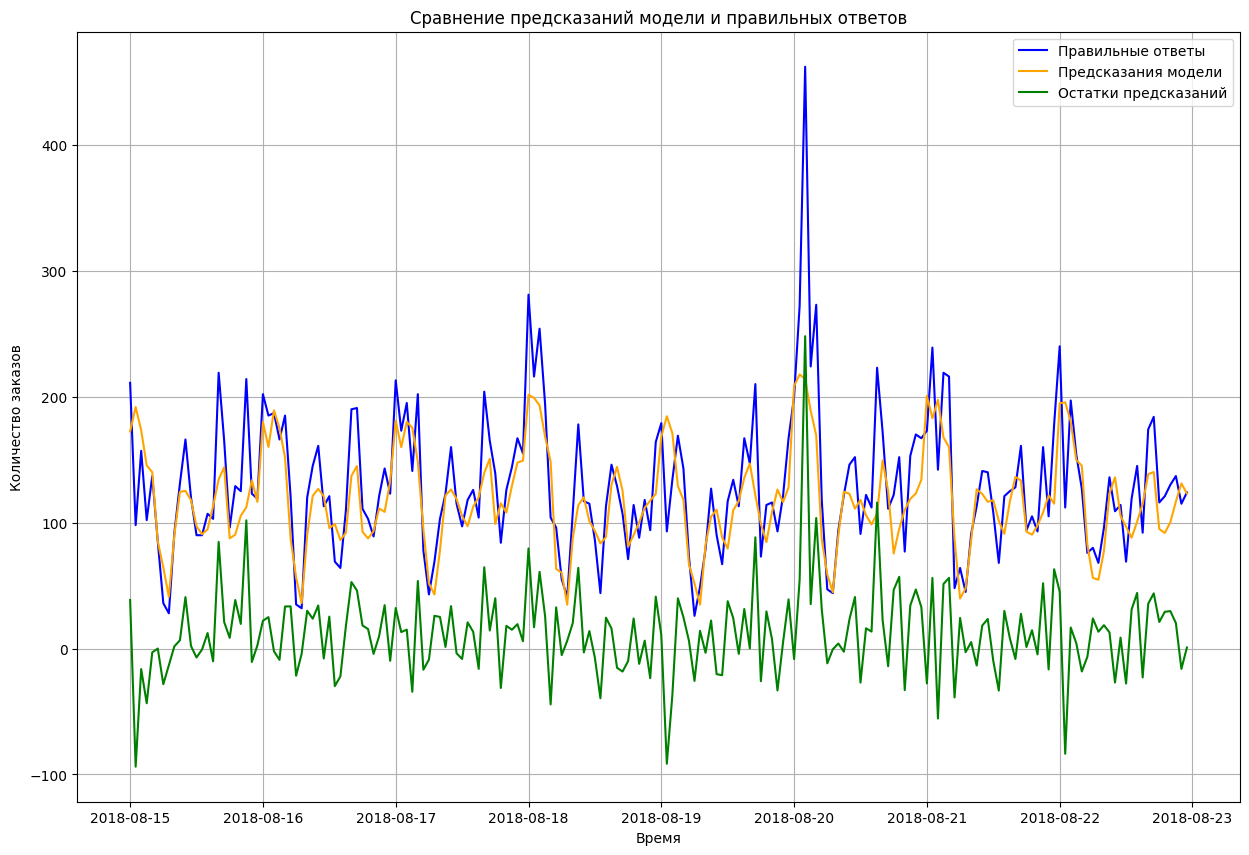

In [84]:
plt.figure(figsize=(15, 10))
plt.plot(results['num_orders'], label='Правильные ответы', color='blue')
plt.plot(results['pred'], label='Предсказания модели', color='orange')
plt.plot(results['resid'], label='Остатки предсказаний', color='green')
plt.title("Сравнение предсказаний модели и правильных ответов")
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()


**The model failed to predict the increase in activity on Monday, August 20, and poorly predicted the drop in activity on Sunday before that.**

**Summary:**
   * The dataset contains taxi order data from March to August 2018
   * The trend in the number of orders is increasing
   * The least popular time to order a taxi is 6 am, the highest peak is around midnight
   * The Dickey-Fuller test shows the time series can be considered stationary
   * The following features were added: day of week, hour, holiday indicator, configurable lag, and rolling mean with a specified window size
   * Training and test sets were formed
   * Two models were trained: Ridge and LightGBM, hyperparameters were tuned